In [1]:
import random, time, ffmpeg
import numpy as np
from math import ceil
import threading
import cv2
from datetime import datetime
import PIL.Image as Image
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
model_settings = {
    # Training settings
    'current_epoch': 1,
    'max_steps': 1000,
    'moving_decay': 0.9999, 'weight_decay': 0.00005, 'dropout': 0.5,
    'learning_rate': 1e-4,  # 1e-4 from previous code
    'checkpoints': 200,  # Number of steps to create checkpoint
    'batch_sizes': [30],  # Batch per device
    'read_pretrained_model': True,
    'load_fc_layers': True,
    'train_conv': False,
    'train_fc': True,
    'save_graph': True,
    'is_testing': False,

    # Neural-Network settings
    'frames_per_batch': 16,  # Number of frames in a batch
    'video_fps': 12,  # FPS of frames extracted
    'crop_size': 112,  # Input frames dimension
    'channels': 3,
    'trans_max': 10,  # Translation factor for pre-processing

    # System settings
    'devices_to_run': ['/gpu:0'],  # Multiple devices are not supported yet :(
    'num_thread': 4,  # Number of threads to read video files
    'queue_size': 3000,  # Queue size for reading input

    # Directory settings
    'read_from_frames': True,
    'model_name': 'UCF_finetune',
    'checkpoint_dir': './checkpoints/',
    'model_save_dir': './models/',
    # 'model_read_loc' : '../ViolanceDetection-Jupyter/models/s1m-ucf101.model',
    'model_read_loc': './models/UCF_finetuneFC_last.model',
    'data_home': '../datasets/UCF-101-Frames/',
    'train_test_loc': '../datasets/UCF-ActionRecognitionSplits',
    'train_file_name': '/trainlist01.txt',
    # 'train_file_name': '/train_small.txt',
    'test_file_name': '/testlist01.txt',
    'mean_clip_loc': '../datasets/PreprocessData/crop_mean.npy'
}


def set_model_settings(model_settings):
    # Storage of variables RAM:'/cpu:0' GPU:'/gpu:0'
    model_settings['variable_storage'] = model_settings['devices_to_run'][0]
    # model_settings['variable_storage'] = '/cpu:0'
    # Total number of batch
    model_settings['total_batch'] = np.sum(model_settings['batch_sizes'])

    # Input shape for placeholders
    model_settings['input_shape'] = (model_settings['frames_per_batch'],
                                     model_settings['crop_size'],
                                     model_settings['crop_size'],
                                     model_settings['channels'])

    # Mean clip for input
    model_settings['np_mean'] = np.load(model_settings['mean_clip_loc']). \
        reshape(model_settings['input_shape'])

    if model_settings['is_testing']:
        model_settings['input_from_placeholders'] = False
        model_settings['dequeue_immediately'] = True
        model_settings['dropout'] = 1.0
        model_settings['trans_max'] = 0
    else:
        model_settings['input_from_placeholders'] = False
        model_settings['dequeue_immediately'] = False

    model_settings['start_time'] = datetime.now()

    
set_model_settings(model_settings)

In [20]:
# Reads train/test filenames from provided splits
# Returns video directions and their labels in a list
def get_data_dir(filename, from_frames=False):
    dir_videos, label_videos = [], []
    with open(filename, 'r') as input_file:
        for line in input_file:
            file_name, label = line.split(' ')
            # if will read from frames
            if from_frames:
                file_name = '.'.join(file_name.split('.')[:-1])
            dir_videos.append(file_name)
            label_videos.append(int(label) - 1)
    return dir_videos, label_videos


# Shuffles video directions along with labels
def shuffle_list(dir_videos, label_videos, seed=time.time()):
    print('Shuffling the dataset...')
    video_indices = list(range(len(dir_videos)))
    random.seed(seed)
    random.shuffle(video_indices)
    shuffled_video_dirs = [dir_videos[i] for i in video_indices]
    shuffled_labels = [label_videos[i] for i in video_indices]
    return shuffled_video_dirs, shuffled_labels


# Given video directory it reads the video
# extracts the frames, and do pre-processing operation
def read_clips_from_video(dirname, model_settings):
    # Input size for the network
    frames_per_batch = model_settings['frames_per_batch']
    video_fps = model_settings['video_fps']
    crop_size = model_settings['crop_size']
    np_mean = model_settings['np_mean']
    trans_max = model_settings['trans_max']

    # Data augmentation randoms
    horizontal_flip = random.random()
    trans_factor = random.randint(-trans_max, trans_max)

    # Video information
    probe = ffmpeg.probe(dirname)
    video_info = probe["streams"][0]
    video_width = video_info["width"]
    video_height = video_info["height"]
    video_duration = float(video_info["duration"])
    num_frame = int(video_info["nb_frames"])

    # Select which portion of the video will be input
    rand_max = int(num_frame - ((num_frame / video_duration) * (frames_per_batch / video_fps)))

    start_frame = random.randint(0, max(rand_max - 1, 0))
    # end_frame = ceil(start_frame + (num_frame / video_duration) * frames_per_batch / video_fps + 1)
    video_start = (video_duration / num_frame) * start_frame
    video_end = min(video_duration, video_start + ((frames_per_batch + 1) / video_fps))

    # Cropping factor
    x_pos = max(video_width - video_height + 2 * trans_factor, 0) // 2
    y_pos = max(video_height - video_width + 2 * trans_factor, 0) // 2
    crop_size1 = min(video_height, video_width)
    # Read specified times of the video
    ff = ffmpeg.input(dirname, ss=video_start, t=video_end - video_start)
    # Trim video -> did not work :(
    # ff = ff.trim(end_frame='50')
    # Divide into frames
    ff = ffmpeg.filter(ff, 'fps', video_fps)
    # Crop
    ff = ffmpeg.crop(ff, x_pos, y_pos, crop_size1, crop_size1)
    # Subsample
    ff = ffmpeg.filter(ff, 'scale', crop_size, crop_size)
    # Horizontal flip with some probability
    if horizontal_flip > 0.5:
        ff = ffmpeg.hflip(ff)
    # Output the video
    ff = ffmpeg.output(ff, 'pipe:',
                       format='rawvideo',
                       pix_fmt='rgb24')
    # Run Process in quiet mode
    out, _ = ffmpeg.run(ff, capture_stdout=True, quiet=True)
    # Extract to numpy array
    video = np.frombuffer(out, np.uint8). \
        reshape([-1, crop_size, crop_size, 3])

    # Copies last frame if # of frames < 16
    # Subtracts the mean and converts type to float32
    num_frames = video.shape[0]
    if num_frames < frames_per_batch:
        last_frame = video[-1]
        num_frame_repeat = frames_per_batch - num_frames
        # print('Frames repeated: ', num_frame_repeat)
        last_repeat = np.repeat(last_frame[np.newaxis],
                                num_frame_repeat,
                                axis=0)
        video = np.concatenate((video, last_repeat), axis=0) - np_mean
    else:
        video = video[:frames_per_batch] - np_mean

    return video


def get_frames_data(filename, frames_per_batch=16):
    ret_arr = []
    for parent, dirnames, filenames in os.walk(filename):
        num_frames = len(filenames)
        start_max = max(0, num_frames - frames_per_batch)
        start_index = random.randint(0, start_max)
        end_index = min(start_index+frames_per_batch, num_frames)
        filenames = sorted(filenames)
        for i in range(start_index, end_index):
            image_name = str(filename) + '/' + str(filenames[i])
            img = Image.open(image_name)
            img_data = np.array(img)
            ret_arr.append(img_data)
    return ret_arr

def set_placeholders(model_settings):
    if model_settings['read_from_frames']:
        shape = (None, None, None, 3)
        images_placeholder = tf.placeholder(tf.float32, shape=shape, name="input_clip")
    else:
        images_placeholder = tf.placeholder(tf.float32, shape=model_settings['input_shape'], name="input_clip")

    labels_placeholder = tf.placeholder(tf.int64, shape=(), name="labels")
    dropout_placeholder = tf.placeholder_with_default(model_settings['dropout'], shape=())

    model_settings['images_placeholder'] = images_placeholder
    model_settings['labels_placeholder'] = labels_placeholder
    model_settings['dropout_placeholder'] = dropout_placeholder
    print('Finished setting placeholders..')


def process_frames(model_settings):
    with tf.name_scope('Frame_Process'), tf.device('/cpu:0'):
        images_placeholder = model_settings['images_placeholder']
        trans_max = model_settings['trans_max']
        crop_size = model_settings['crop_size']
        frames_per_batch = model_settings['frames_per_batch']
        np_mean = tf.convert_to_tensor(model_settings['np_mean'])

        clips_shape = tf.shape(images_placeholder)
        video_width = clips_shape[1]
        video_height = clips_shape[2]
        rem_frame = frames_per_batch - clips_shape[0]

        trans_factor = tf.random.uniform([1], -trans_max, trans_max, dtype=tf.int32)
        crop_size1 = tf.math.minimum(video_height, video_width)
        x_pos = tf.math.maximum(video_width - video_height + 2 * trans_factor, 0) // 2
        x_start, x_end = x_pos[0], x_pos[0]+crop_size1
        y_pos = tf.math.maximum(video_height - video_width + 2 * trans_factor, 0) // 2
        y_start, y_end = y_pos[0], y_pos[0]+crop_size1

        clips_cropped = images_placeholder[:,x_start:x_end, y_start:y_end]
        clips_interp = tf.image.resize_bicubic(clips_cropped, (crop_size, crop_size))
        clips_interp = tf.clip_by_value(clips_interp, 0, 255)
        last_frame = clips_interp[-1]
        rem_frames = tf.tile(tf.expand_dims(last_frame,0), [rem_frame, 1, 1, 1])
        final_clips = tf.concat([clips_interp, rem_frames], 0)
        final_clips = tf.image.random_flip_left_right(final_clips)
        final_clips -= np_mean
    return final_clips


def read_clips(dirnames, model_settings):
    for dirname in dirnames:
        read_clip(dirname, model_settings)

In [21]:
train_dir_locations = model_settings['train_test_loc'] + model_settings['train_file_name']
dir_frames, labels = get_data_dir(train_dir_locations, True)

Finished setting placeholders..


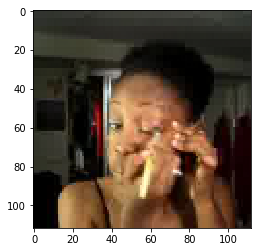

In [48]:
set_placeholders(model_settings)
frames = process_frames(model_settings)

i = random.randint(0, 5000)
file_loc = model_settings['data_home'] + dir_frames[i]    
imgs = get_frames_data(file_loc)
images_placeholder = model_settings['images_placeholder']

with tf.Session() as sess:
    frames = sess.run(frames, {images_placeholder: imgs})
plt.imshow(frames[0].astype(np.uint8))
plt.show()

In [ ]:
dirnames_threads = []
threads = []

for i in range(8):
    cur = []
    for j in range(5):
        read_index = 5 * i + j
        video_dir, label = dir_videos[read_index], label_clips[read_index]
        video_dir = model_settings['data_home'] + video_dir
        cur.append(video_dir)
    dirnames_threads.append(cur)


for i in range(8):
    dirnames = dirnames_threads[i]
    threads.append(threading.Thread(target=read_clips, args=(dirnames, model_settings)))

time0 = time.time()
for i in range(8):
    threads[i].start()

for i in range(8):
    threads[i].join()
print('Time diff:', time.time() - time0)

In [ ]:
index = 150
dirname = model_settings['data_home'] + dir_videos[index]
frames_per_batch = model_settings['frames_per_batch']
video_fps = model_settings['video_fps']
crop_size = model_settings['crop_size']
np_mean = model_settings['np_mean']
horizontal_flip = random.random()

probe = ffmpeg.probe(dirname)
video_info = probe["streams"][0]
video_width = video_info["width"]
video_height = video_info["height"]
video_duration = float(video_info["duration"])
num_frame = int(video_info["nb_frames"])

rand_max = int(num_frame - ((num_frame / video_duration) * (frames_per_batch / video_fps)))
start_frame = random.randint(0, rand_max - 1)
end_frame = ceil(start_frame + (num_frame / video_duration) * frames_per_batch / video_fps + 1)
video_start = (video_duration / num_frame) * start_frame
video_end = video_start + ((frames_per_batch+1) / video_fps) 
print(end_frame-start_frame, video_start, video_end)

x_pos = max(video_width - video_height, 0) // 2
y_pos = max(video_height - video_width, 0) // 2
crop_size1 = min(video_height, video_width)


In [ ]:
# Input video
ff = ffmpeg.input(dirname, ss=video_start, t=video_end-video_start)
# Trim video
#ff = ff.trim(end_frame='50')
# Divide into frames
ff = ffmpeg.filter(ff, 'fps', video_fps)
# Crop
ff = ffmpeg.crop(ff, x_pos, y_pos, crop_size1, crop_size1)
# Subsample
ff = ffmpeg.filter(ff, 'scale', crop_size, crop_size)
# Horizontal flip with some probability
if horizontal_flip > 0.5:
    ff = ffmpeg.hflip(ff)
# Output the video
ff = ffmpeg.output(ff, 'pipe:',
                   format='rawvideo',
                   pix_fmt='rgb24')
# Run Process in quiet mode
out, _ = ffmpeg.run(ff, capture_stdout=True, quiet=True)
# Extract to numpy array
video = np.frombuffer(out, np.uint8). \
    reshape([-1, crop_size, crop_size, 3])

# Substracts the mean and converts type to float32
video = video[:16] - np_mean
#print(video.shape)


In [ ]:
index = 150
dirname = model_settings['data_home'] + dir_videos[index]
frames_per_batch = model_settings['frames_per_batch']
video_fps = model_settings['video_fps']
crop_size = model_settings['crop_size']
np_mean = model_settings['np_mean']
horizontal_flip = random.random()

probe = ffmpeg.probe(dirname)
video_info = probe["streams"][0]
video_width = video_info["width"]
video_height = video_info["height"]
video_duration = float(video_info["duration"])
num_frame = int(video_info["nb_frames"])

rand_max = int(num_frame - ((num_frame / video_duration) * (frames_per_batch / video_fps)))
start_frame = random.randint(0, rand_max - 1)
end_frame = ceil(start_frame + (num_frame / video_duration) * frames_per_batch / video_fps + 1)
#end_frame = min(end_frame, num_frame)

x_pos = max(video_width - video_height, 0) // 2
y_pos = max(video_height - video_width, 0) // 2
crop_size1 = min(video_height, video_width)